**извлечение признаков из текста на естественном языке**

кластеризатор текстов   
SnowballStemmer + TFIDF + DBSCAN

_Евгений Борисов <esborisov@sevsu.ru>_

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm.notebook import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [2]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN

from matplotlib import pyplot as plt

SKLEARN_VERSION

'1.0.2'

In [3]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords
# from nltk import download as nltk_download
# nltk_download('stopwords')

## тексты

In [4]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [5]:
data.sample(2)

,text,tag
2638,"Ученые из Хельсинки выяснили, сколько времени на самом деле нужно спать по ночам, чтобы как следует высыпаться и хорошо себя чувствовать. Научным сотрудникам понадобилось провести целый ряд испыта...",science
2974,"Разработчики Alfa Romeo 4C могут создать версию Quadrifoglio\n\nПо неподтверждённой информации, итальянский эксклюзивный бренд может создать версию Quadrifoglio для модели Alfa Romeo 4C.\n\n\n\n\n...",auto


## токенизация и очистка

In [6]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

In [7]:
data['ctext'] = data['text'].progress_apply(string_normalizer)

  0%|          | 0/3196 [00:00<?, ?it/s]

##  Vectorizer

In [8]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set(nltk_stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

# разрезаем стоки на слова, выкидываем stopwords, выполняем стеминг
def tokenizer_stemmer(s,stemmer=stemmer,stopwords=stopwords): 
    for w in s.split(' '):
        o = stemmer.stem(w).replace('^','')
        if len(o)<2: continue
        if o in stopwords: continue
        yield o        

In [9]:
%%time

X = TfidfVectorizer(
        use_idf=True,
        norm='l2',
        tokenizer=tokenizer_stemmer,
        token_pattern=None,
    ).fit_transform( data['ctext'] )

CPU times: user 1min 16s, sys: 49.5 ms, total: 1min 16s
Wall time: 1min 17s


In [10]:
X.shape

(3196, 36354)

## кластеризируем

In [11]:
data['cluster'] = DBSCAN(eps=.85,min_samples=5).fit(X).labels_
data['cluster'].drop_duplicates().count()

52

## тестируем

In [12]:
# номер кластера, количество объектов, метки объектов
# (cluster=-1 - некластеризованные DBSCAN объекты)
cluster_descr = pd.concat([
        data[['cluster','tag']].groupby(['cluster'])['tag'].count(),
        data[['cluster','tag']].groupby(['cluster'])['tag'].apply(lambda s: set(s)).apply(' '.join)
    ],axis=1).reset_index()

cluster_descr.columns = ['cluster','count','tags']

cluster_descr

,cluster,count,tags
0,-1,2765,reclama auto science realty politics health sport economics social woman incident tech culture
1,0,6,economics
2,1,21,politics
3,2,9,politics
4,3,13,politics
5,4,5,politics
6,5,27,politics
7,6,5,politics
8,7,10,incident
9,8,12,politics


<AxesSubplot:xlabel='cluster'>

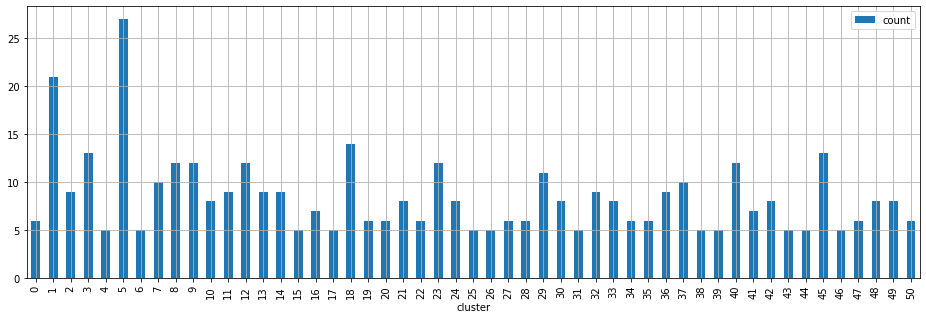

In [13]:
# размеры кластеров
cluster_descr[['cluster','count']]\
    .query('cluster>-1')\
    .set_index('cluster')\
    .plot.bar(grid=True,figsize=(16,5))

In [14]:
def print_cluster_samples(n,ns=3,nt=300):
    count,tags = cluster_descr.query(f'cluster=={n}')[['count','tags']].values[0]#.tolist
    df = data.query(f'cluster=={n}')
    ns_ = min(ns,len(df))
    top = [ t[:nt].replace('\n',' ') for t in df['text'].sample(ns_).values ]
    print('[ КЛАСТЕР %i, элементов: %i, метки: "%s" ]'%(n,count,tags))
    for s in top: print('\n%s ...\n'%(s) )

In [15]:
for n in rng.permutation(cluster_descr['cluster'].max())[:3] :
    print_cluster_samples(n)
    print('\n= = = = = = = = = = = = = = = = = = = = = = = = = =\n')

[ КЛАСТЕР 41, элементов: 7, метки: "science tech" ]

Москва, 13 декабря. АО «Гознак» получило несколько патентов, призванных защитить деньги и другие ценные бумаги от подделки. В частности, речь идет об изготовлении денег с прозрачными участками, а также бумаги с волокнами, флуоресцирующими в обычном видимом свете. Об этом сообщается в базах данных Ро ...


Российские деньги станут частично прозрачными и будут светиться, - такие новшества внедряет завод по производству купюр АО «Гознак». Новые технологии призваны усилить защиту денег от подделки.  Предприятию «Гознак» выданы новые патенты на защиту купюр, передает «Лайф». Один патент касается бумаги с  ...


АО «Гознак» будет изготавливать денежные купюры с прозрачными участками для повышения безопасности от подделки. Отмечается, что в данных Роспатента, информация о технологиях Гознака уже имеется.  Согласно патенту, прозрачные участки на банкнотах будут делаться с помощью локальной пропитки бумаги гли ...


= = = = = = = = = = = = = 